# Liquid movement

Begin by importing the relevant packages.

In [1]:
import numpy as np; 
import control as ctrl; 
import cvxpy as cp

(CVXPY) Oct 12 10:58:36 PM: Encountered unexpected exception importing solver OSQP:
ImportError('DLL load failed while importing qdldl: Das angegebene Modul wurde nicht gefunden.')


Next, define the continuous-time system dynamics and represent it as a state-space object.

In [2]:
zeta=0; omega0=21; a=0.07; g=9.81; L=0.2
Ac=np.array([[-2*zeta*omega0, -omega0, 0, 0],[omega0, 0, 0, 0],[0, 0, 0, 0],[0, 0, 1, 0]])
Bc=np.array([[a*omega0/(2*g),0,1,0]]).T; Cc=np.array([[0,1,0,0],[0,0,0,1]]); Dc=np.array([[0,0]]).T
sysc=ctrl.ss(Ac,Bc,Cc,Dc)

Choose sampling time, convert to discrete-time and extract system matrices.

In [3]:
h=1e-3
sysd=ctrl.c2d(sysc,h)
(A,B,C,D)=ctrl.ssdata(sysd)

Define optimal control problem using cvxpy.


In [4]:
#exit()
(n,m)=B.shape

Tf=0.383; T = int(Tf/h)
smax=0.035; umax=g

x0=np.array([[0,0,0,0]]).T; xT=np.array([[0,0,0,L]]).T;

x=cp.Variable((n,T+1))
u=cp.Variable((m,T))
cost=cp.sum_squares(u)
constr = [ x[:,[0]]==x0 ]
for t in range(T):
    constr+=[ x[:,t+1]==A@x[:,t]+B@u[:,t]]
    constr+=[-umax<= u[:,t], u[:,t]<=umax]
    constr+=[-smax<=C[0,:]@x[:,t], C[0,:]@x[:,t]<=smax]
constr+= [ x[:,[T]]==xT]
problem=cp.Problem(cp.Minimize(cost), constr);
problem.solve(solver='MOSEK');

Finally, plot the resulting optimal solution and associated state trajectories.

Text(0.5, 0, 'Sample index')

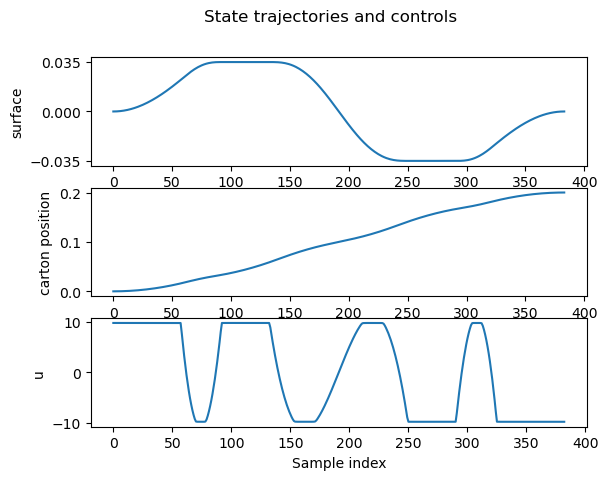

In [6]:
import matplotlib.pyplot as plt
# Plot results
fig, axs = plt.subplots(3)
fig.suptitle('State trajectories and controls')
axs[0].plot(x[1,:].value)
axs[0].set_ylabel('surface')
axs[0].set_yticks([-0.035, 0, 0.035])
axs[1].plot(x[3,:].value)
axs[1].set_ylabel('carton position')
axs[2].plot(u[0,:].value)
axs[2].set_ylabel('u');
axs[2].set_xlabel('Sample index')